# Загружаем веса модели, лэйбд энкодер и предсказываем одну картинку

In [1]:
import pickle
import numpy as np

from PIL import Image
from pathlib import Path
from io import BytesIO

import torch
from torchvision import models
import torch.nn as nn
from torchvision import transforms

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
from torchvision import models
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

import requests
import io


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
RESCALE_SIZE = 232

In [2]:
model_resnet = models.resnet50(weights=None).to(DEVICE)
for i, child in enumerate(model_resnet.children()):
    if i not in [9]:
        for param in child.parameters():
            param.requires_grad = False

model_resnet.fc = nn.Sequential(nn.Linear(2048, 525))
model_resnet.load_state_dict(torch.load("birds/model_weights_50_best.pth"))
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [3]:
def predict_image(model, image, device=DEVICE):
    model = model.to(device)
    transform = transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE,RESCALE_SIZE)),
                transforms.CenterCrop(size=224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    response = requests.get(image).content
    image = Image.open(io.BytesIO(response)).convert("RGB")
    image_trans = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        inputs = image_trans.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
        
    max_prob = probs.max() * 100
    y_pred_argmax = np.argmax(probs, -1)
    pred_class = label_encoder.classes_[y_pred_argmax]
    if max_prob > 60:
        y_pred_argmax = np.argmax(probs, -1)
        pred_class = label_encoder.classes_[y_pred_argmax]
        print(pred_class[0], probs.max() * 100)
    else:
        idx = np.argsort(probs[-1])[-3:][::-1]
        y_preds = [probs[-1][i] for i in idx]
        # actual_labels = label_encoder.classes_[val_dataset[random_characters][1]]
        for i, y_pred in zip(idx, y_preds):
            preds_class = label_encoder.classes_[i]
            print(preds_class, y_pred * 100)    
    
    predicted_text = "{}: {:.0f}%".format(pred_class[0], max_prob)
    fig, ax = plt.subplots(figsize=(5,5))
    # ax.add_patch(patches.Rectangle((-1, 200), 200, 25, facecolor='white', edgecolor='black'))
    # ax.text(1, 210, predicted_text , horizontalalignment='left', verticalalignment='top', fontsize=8, color='black', fontweight='bold')
    ax.imshow(image)
    ax.set_title(predicted_text, fontsize=14, fontweight="bold")
    ax.set_axis_off()

In [4]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Rose_Ringed_Parrot.jpg/220px-Rose_Ringed_Parrot.jpg"
# url = "https://upload.wikimedia.org/wikipedia/commons/thumb/6/6d/Blue-and-Yellow-Macaw.jpg/800px-Blue-and-Yellow-Macaw.jpg"
# url = "https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcTP8QaJWaDypUUp7_4JyNgj5tUXLQVN55Nxn--470sK3eE1G_bjgW1d4QuFb1jbFfF75wGFeq8hGTHMdUo"
# url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/126386161/1800"
# url = "https://encrypted-tbn3.gstatic.com/licensed-image?q=tbn:ANd9GcRFRrKBnz6feen977avyCZHezOudHz_OzvT5KmSvOAzj_nqqBmwDs7_DmkixiFjvewsrB9kIcFaa_CJ3NA"
# url = "https://ucnj.org/falcon-camera/wp-content/uploads/sites/36/2022/04/image-2.png"
# url = "https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcR40UICS-9g2Qhi_HJr_8EtTxM2C6xKepC2BS6fndGlqM1HddnUsSOn9Jc71n4usRXaf4UosMg9SHj3Cdk"
# url = "https://i.ytimg.com/vi/DPiH7xAfZzs/maxresdefault.jpg"
# url = "https://cdn.download.ams.birds.cornell.edu/api/v1/asset/144016211/1800"
# url = "https://www.allaboutbirds.org/guide/assets/photo/303618951-480px.jpg"
# url = "https://thumbs.dreamstime.com/b/australian-sulphur-crested-cockatoo-kakadu-27983555.jpg"
# url = "https://www.gannett-cdn.com/presto/2023/04/27/USAT/9e5ff064-73df-4980-9490-b8fe05dcfabb-041023_MM_Jennifer_Cunha_067.JPG?crop=1399,787,x0,y70&width=1399&height=699&format=pjpg&auto=webp"
# url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeHVZIWVht83xXi2BloPD7A3SRlOdaSmgwpA9CJ-vJSnHhCGGuUjfjMAJisGLYvfR7BEA&usqp=CAU"
response = requests.get(url).content
im = Image.open(io.BytesIO(response)).convert('RGB')

ALEXANDRINE PARAKEET 99.99988079071045


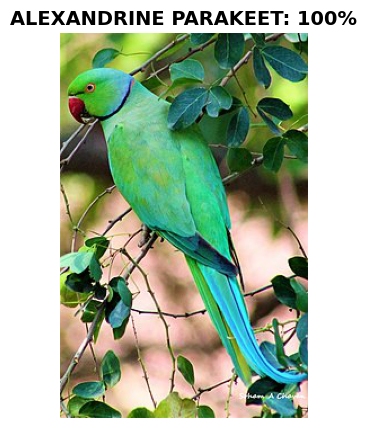

In [5]:
predict_image(model_resnet, url)